In [ ]:
'''
Soft Actor-Critic version 2
using target Q instead of V net: 2 Q net, 2 target Q net, 1 policy net
add alpha loss compared with version 1
paper: https://arxiv.org/pdf/1812.05905.pdf
'''

import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import argparse
import time
from matplotlib import pyplot as plt
from copy import deepcopy
import itertools
import torchvision
from torchvision import transforms, utils, models,datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
from __future__ import print_function
import os
import csv
import math
from typing import Optional, Union

from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

#Import dataset and build train/test loader + train/test function

##Train and test function

In [ ]:
def train( model, device, train_loader, optimizer, epoch,loss_fn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            


def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

##Import dataset and build train/test loaders

In [ ]:
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_data = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_data = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# takes the first 10% images of MNIST train set
subset_train = Subset(train_data, indices=range(len(train_data) // 10))
subset_test = Subset(test_data, indices=range(len(test_data) // 10))

train_loader = torch.utils.data.DataLoader(subset_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(subset_test, **test_kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [ ]:
print(f'Size training set before subset:{len(train_data)}')
print(f'Size test set before subset:{len(test_data)}')
print(f'Training set size :{len(subset_train)}')
print(f'Test set size :{len(subset_test)}')

Size training set before subset:50000
Size test set before subset:10000
Training set size :5000
Test set size :1000


#SAC

## Device selection

In [ ]:
#device config
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


##class ReplayBuffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

##Class NormalizedActions

In [ ]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return action

##Class value Network

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, 1)
        # weights initialization
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

##class SoftQNetwork

In [ ]:
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, 1)
        
        self.linear4.weight.data.uniform_(-init_w, init_w)
        self.linear4.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1) # the dim 0 is number of samples
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

##Class Policy Network

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, action_range=1., init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)

        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)

        self.action_range = action_range
        self.num_actions = num_actions

        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))

        mean    = (self.mean_linear(x))
        # mean    = F.leaky_relu(self.mean_linear(x))
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        '''
        generate sampled action with state as input wrt the policy network;
        '''
        mean, log_std = self.forward(state)
        std = log_std.exp() # no clip in evaluation, clip affects gradients flow
        
        normal = Normal(0, 1)
        z      = normal.sample(mean.shape) 
        action_0 = torch.tanh(mean + std*z.to(device)) # TanhNormal distribution as actions; reparameterization trick
        action = self.action_range*action_0
        # The log-likelihood here is for the TanhNorm distribution instead of only Gaussian distribution. \
        # The TanhNorm forces the Gaussian with infinite action range to be finite. \
        # For the three terms in this log-likelihood estimation: \
        # (1). the first term is the log probability of action as in common \
        # stochastic Gaussian action policy (without Tanh); \
        # (2). the second term is the caused by the Tanh(), \
        # as shown in appendix C. Enforcing Action Bounds of https://arxiv.org/pdf/1801.01290.pdf, \
        # the epsilon is for preventing the negative cases in log; \
        # (3). the third term is caused by the action range I used in this code is not (-1, 1) but with \
        # an arbitrary action range, which is slightly different from original paper.
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1. - action_0.pow(2) + epsilon) -  np.log(self.action_range)
        # both dims of normal.log_prob and -log(1-a**2) are (N,dim_of_action); 
        # the Normal.log_prob outputs the same dim of input features instead of 1 dim probability, 
        # needs sum up across the features dim to get 1 dim prob; or else use Multivariate Normal.
        log_prob = log_prob.sum(dim=1, keepdim=True)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state, deterministic):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample(mean.shape).to(device)
        action = self.action_range* torch.tanh(mean + std*z)
        
        action = self.action_range* torch.tanh(mean).detach().cpu().numpy()[0] if deterministic else action.detach().cpu().numpy()[0]
        return action


    def sample_action(self,):
        a=torch.FloatTensor(self.num_actions).uniform_(-1, 1)
        return self.action_range*a.numpy()

##Class SAC Trainer

In [ ]:
class SAC_Trainer():
    def __init__(self, replay_buffer, hidden_dim, action_range):
        self.replay_buffer = replay_buffer

        self.soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.target_soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, action_range).to(device)
        self.log_alpha = torch.zeros(1, dtype=torch.float32, requires_grad=True, device=device)
        print('Soft Q Network (1,2): ', self.soft_q_net1)
        print('Policy Network: ', self.policy_net)

        for target_param, param in zip(self.target_soft_q_net1.parameters(), self.soft_q_net1.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_soft_q_net2.parameters(), self.soft_q_net2.parameters()):
            target_param.data.copy_(param.data)

        self.soft_q_criterion1 = nn.MSELoss()
        self.soft_q_criterion2 = nn.MSELoss()

        soft_q_lr = 3e-4
        policy_lr = 3e-4
        alpha_lr  = 3e-4

        self.soft_q_optimizer1 = optim.Adam(self.soft_q_net1.parameters(), lr=soft_q_lr)
        self.soft_q_optimizer2 = optim.Adam(self.soft_q_net2.parameters(), lr=soft_q_lr)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=policy_lr)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)

    
    def update(self, batch_size, reward_scale=10., auto_entropy=True, target_entropy=-2, gamma=0.99,soft_tau=1e-2):
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        #print(f'sample state:{state}, action:{action},  reward:{reward}, done:{done}')

        state      = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)  # reward is single value, unsqueeze() to add one dim to be [reward] at the sample dim;
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        predicted_q_value1 = self.soft_q_net1(state, action)
        predicted_q_value2 = self.soft_q_net2(state, action)
        new_action, log_prob, z, mean, log_std = self.policy_net.evaluate(state)
        new_next_action, next_log_prob, _, _, _ = self.policy_net.evaluate(next_state)
        reward = reward_scale * (reward - reward.mean(dim=0)) / (reward.std(dim=0) + 1e-6) # normalize with batch mean and std; plus a small number to prevent numerical problem
    # Updating alpha wrt entropy
        # alpha = 0.0  # trade-off between exploration (max entropy) and exploitation (max Q) 
        if auto_entropy is True:
            alpha_loss = -(self.log_alpha * (log_prob + target_entropy).detach()).mean()
            # print('alpha loss: ',alpha_loss)
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp()
        else:
            self.alpha = 1.
            alpha_loss = 0

    # Training Q Function
        target_q_min = torch.min(self.target_soft_q_net1(next_state, new_next_action),self.target_soft_q_net2(next_state, new_next_action)) - self.alpha * next_log_prob
        target_q_value = reward + (1 - done) * gamma * target_q_min # if done==1, only reward
        q_value_loss1 = self.soft_q_criterion1(predicted_q_value1, target_q_value.detach())  # detach: no gradients for the variable
        q_value_loss2 = self.soft_q_criterion2(predicted_q_value2, target_q_value.detach())


        self.soft_q_optimizer1.zero_grad()
        q_value_loss1.backward()
        self.soft_q_optimizer1.step()
        self.soft_q_optimizer2.zero_grad()
        q_value_loss2.backward()
        self.soft_q_optimizer2.step()  

    # Training Policy Function
        predicted_new_q_value = torch.min(self.soft_q_net1(state, new_action),self.soft_q_net2(state, new_action))
        policy_loss = (self.alpha * log_prob - predicted_new_q_value).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # print('q loss: ', q_value_loss1, q_value_loss2)
        # print('policy loss: ', policy_loss )


    # Soft update the target value net
        for target_param, param in zip(self.target_soft_q_net1.parameters(), self.soft_q_net1.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
        for target_param, param in zip(self.target_soft_q_net2.parameters(), self.soft_q_net2.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
        return predicted_new_q_value.mean()

    def save_model(self, path):
        torch.save(self.soft_q_net1.state_dict(), path+'_q1')
        torch.save(self.soft_q_net2.state_dict(), path+'_q2')
        torch.save(self.policy_net.state_dict(), path+'_policy')

    def load_model(self, path):
        self.soft_q_net1.load_state_dict(torch.load(path+'_q1'))
        self.soft_q_net2.load_state_dict(torch.load(path+'_q2'))
        self.policy_net.load_state_dict(torch.load(path+'_policy'))

        self.soft_q_net1.eval()
        self.soft_q_net2.eval()
        self.policy_net.eval()

##Class MetaRLEnv

In [ ]:
class MetaRLEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ### Description

    ### Action Space

    The action is a `ndarray` with shape `(1,)` of continuous value between 1e-6 and 1e-2. It sets the new value for the learning rate used 
    for the scheduling step.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | lr     | 1e-5 | 1e-2 |

    
    ### Observation Space

    The observation is a `ndarray` with shape `(2,)` with the values corresponding to the following positions and velocities:

    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | current lr            | 1e-5                |  1e-2             |
    | 1   | accuracy              | 0                   | 1                 |
    | 2   | Bacth_size            | 20                  | 200               |
   
  
    ### Rewards

    Reward = difference of accuracy with previous step
    r = new_accuracy - prev_accuracy

    ### Starting State

    Init state = [1e-3,0,64]

    ### Episode End

    The episode ends if any one of the following occurs:

    1. Termination: lr<0 or lr>1
    2. Termination: Iter > N_iters

    ### Data loader using batch size
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
    
    """

    def __init__(self,train_dataset, test_dataset,device):
        super(MetaRLEnv, self).__init__()   
        self.max_lr = 1e-2
        self.min_lr = 1e-5
        self.min_batch = 20
        self.max_batch = 200
        ###### INIT INNER MODEL
        
        self.device = device
        self.train_dataset = train_dataset
        self.test_dataset= test_dataset
        self.loss_fn = nn.CrossEntropyLoss()

        #####
        self.prev_state = None
        self.lr_list = []
        self.batch_size_list = []
        self.episode_number = 0
        self.epoch = 1
        
        ######################## Boundaries of observation space
        high = np.array(
            [   self.max_lr, #max bound lr
                1, #max bound accuracy
                self.max_batch,#batch size limits when added,
            ],
            dtype=np.float32,)

        low = np.array(
            [
                self.min_lr,
                0,
                self.min_batch,#batch size limits,
            ],
            dtype=np.float32,)
        ######################## Define research space
        self.action_space = spaces.Box(low=self.min_lr, high=self.max_lr, shape=(1,), dtype=np.float32)
        #Check because batch_size is an integer
        #self.action_space = spaces.Box(low=np.array([self.min_lr,self.min_batch]), high = np.array([self.max_lr,self.max_batch]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        self.history_params = {"lr":[1e-3],"accuracy":[0],"batch_size":[64]}


    def step(self,lr_pred):

        ##store prec state
        self.prev_state = self.state
        #ensure right values
        lr_pred = np.clip(lr_pred, self.min_lr, self.max_lr)[0]
        #to check
        self.last_lr = lr_pred
        # store batch_size
        self.batch_size = 64


        ##Compute train loader (for the case with the batch size) where here batch_size <- self.state[2]
        train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset,
                                           batch_size=self.batch_size, 
                                           shuffle=True)

        test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset,
                                          batch_size=self.batch_size, 
                                          shuffle=False)
        
        #perform action = scheduling step only if validation error increase
        if (self.prev_state[1]>self.state[1])or(self.epoch%3==0):
          for param_group in self.optimizer.param_groups:
              param_group['lr'] = lr_pred
              self.lr_list.append(lr_pred)

        #transition of the environmebnt
        train(self.model, self.device, train_loader, self.optimizer, self.epoch,self.loss_fn)
        new_acc = test(self.model, self.device, test_loader,self.loss_fn)

        #update state
        self.state = np.array([lr_pred, new_acc,self.batch_size],dtype = np.float32)
        self.epoch+=1
      
        print(f"Episode:{self.episode_number} Epoch:{self.epoch} : current lr:{self.state[0]} and previous:{self.prev_state[0]} and new_acc:{self.state[1]} and previous :{self.prev_state[1]}")
        
        #compute reward function
        reward = self.reward_function("acc_diff")
        #save reward
        self.save_reward(reward,self.epoch)
        
        # Write to the history buffers
        self.write_history_params()

        return np.array(self.state, dtype=np.float32), reward, False, False, {}

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)

        #not a random init state
        self.state = np.array([1e-3,0,64])
        self.last_lr = None

        #reset model
        self.model = models.resnet18(pretrained=False).to(device) #for the next episode, reset the model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3) #reset the optimizer

        #output data previous episode
        if self.episode_number >0: #si on a deja commencé le training
          self.output_data()
        #init history buffer  
        self.history_params = {}
        self.history_params = {"lr":[self.state[0]], "accuracy":[self.state[1]],"batch_size":[64]}
        self.episode_number +=1
        self.epoch = 1

        return np.array(self.state, dtype=np.float32), {}

    def reward_function(self,reward_fn):
      '''
      Take as input the choice of reward function used and return the reward computed
      '''
      if reward_fn =="cartpole_like":
        return (self.state[1]-self.prev_state[1])*1
      elif reward_fn == "acc_diff":
        return self.state[1]-self.prev_state[1]
    
    def write_history_params(self):
        self.history_params["lr"].append(self.state[0])
        self.history_params["accuracy"].append(self.state[1])
        self.history_params["batch_size"].append(self.batch_size)
    
    def save_reward(self, reward,epoch):
        '''
        Outputs a file with the reward every epoch of the learning episode
        '''
        name = "rewards.csv"
        if (not os.path.exists(name)):
            with open(name, "w") as csv_file:
                spam_writer = csv.writer(csv_file, delimiter=";", lineterminator="\n")
                spam_writer.writerow(["Episode","Epoch", "Reward"])
                spam_writer.writerow([self.episode_number,epoch, reward])
        else:
            with open(name, "a") as csv_file:
                spam_writer = csv.writer(csv_file, delimiter=";", lineterminator="\n")
                spam_writer.writerow([self.episode_number, epoch, reward])
    
    def output_data(self):
      '''
      Output .csv file with all the training data
      '''
      name = "output.csv"
      if (not os.path.exists(name)):
            with open(name, "w") as csv_file:
                spam_writer = csv.writer(csv_file, delimiter=";", lineterminator="\n")
                spam_writer.writerow(["Episode","Epoch","lr","batch_size","accuracy"])
                for epoch in range(len(self.history_params["lr"])):
                  spam_writer.writerow([self.episode_number,epoch,self.history_params["lr"][epoch],self.history_params["batch_size"][epoch], self.history_params['accuracy'][epoch]])
      else:
          with open(name, "a") as csv_file:
              spam_writer = csv.writer(csv_file, delimiter=";", lineterminator="\n")
              for epoch in range(len(self.history_params["lr"])):
                  spam_writer.writerow([self.episode_number,epoch,self.history_params["lr"][epoch],self.history_params["batch_size"][epoch], self.history_params['accuracy'][epoch]])

    


## Function to Plot rewards

In [ ]:
def plot(rewards):
    plt.figure(figsize=(20,5))
    plt.plot(rewards)
    plt.savefig('sac_v2.png')
    # plt.show()

#Training

In [ ]:
#Sizing replay buffer
replay_buffer_size = 1e6
replay_buffer = ReplayBuffer(replay_buffer_size)

In [ ]:
# choose env

#env = NormalizedActions(MetaRLEnv(train_loader, test_loader, device))
env = MetaRLEnv(train_loader,test_loader,device)
action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
action_range=1.

##Hyperparams

In [ ]:
# hyper-parameters for RL training
if torch.cuda.is_available():
    N_EPISODE = 100 #used 1000 for pendulum env for comparison
else:
    N_EPISODE = 20

#inner epoch for the inner model
inner_epochs = 10

BATCH_SIZE  = 20 #init =300
explore_steps = 0  # for random action sampling in the beginning of training
update_itr = 1
AUTO_ENTROPY=True
DETERMINISTIC=False
hidden_dim = 128 #init 300
rewards     = []
model_path = './model_meta_rl_sac'

#check if it is training or testing
is_train = True
is_test=False

In [ ]:
sac_trainer=SAC_Trainer(replay_buffer, hidden_dim=hidden_dim, action_range=action_range)

Soft Q Network (1,2):  SoftQNetwork(
  (linear1): Linear(in_features=4, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=1, bias=True)
)
Policy Network:  PolicyNetwork(
  (linear1): Linear(in_features=3, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=128, bias=True)
  (mean_linear): Linear(in_features=128, out_features=1, bias=True)
  (log_std_linear): Linear(in_features=128, out_features=1, bias=True)
)


##Main training loop

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Train Epoch: 9 [3200/5000 (63%)]	Loss: 1.715632
Train Epoch: 9 [3840/5000 (76%)]	Loss: 1.644037
Train Epoch: 9 [4480/5000 (89%)]	Loss: 2.049771

Test set: Accuracy: 377/1000 (38%)

Episode:112 Epoch:10 : current lr:0.009999999776482582 and previous:0.009999999776482582 and new_acc:0.377 and previous :0.344
next_state:[ 0.01   0.377 10.   ]
Train Epoch: 10 [0/5000 (0%)]	Loss: 1.813818
Train Epoch: 10 [640/5000 (13%)]	Loss: 1.912201
Train Epoch: 10 [1280/5000 (25%)]	Loss: 1.805677
Train Epoch: 10 [1920/5000 (38%)]	Loss: 1.938559
Train Epoch: 10 [2560/5000 (51%)]	Loss: 1.516474
Train Epoch: 10 [3200/5000 (63%)]	Loss: 1.698496
Train Epoch: 10 [3840/5000 (76%)]	Loss: 1.636158
Train Epoch: 10 [4480/5000 (89%)]	Loss: 1.869111

Test set: Accuracy: 391/1000 (39%)

Episode:112 Epoch:11 : current lr:9.999999747378752e-06 and previous:0.009999999776482582 and new_acc:0.391 and previous :0.377
next_state:[1.00e-05 3.91e-0

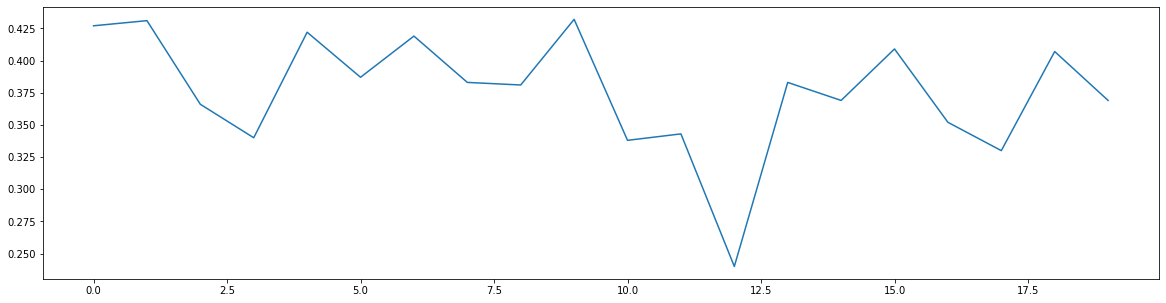

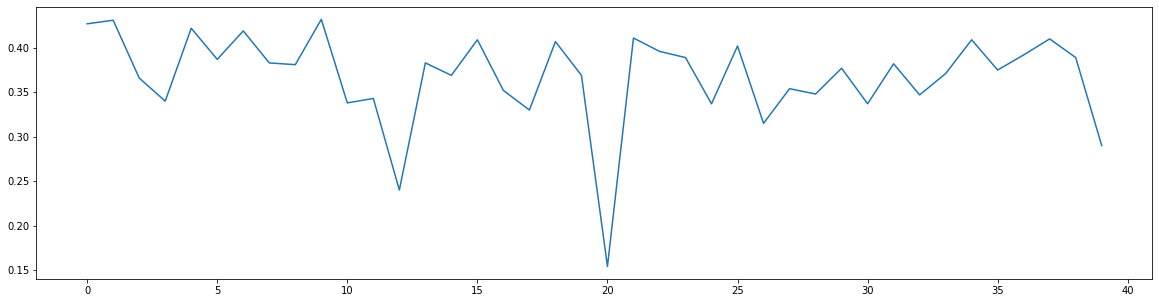

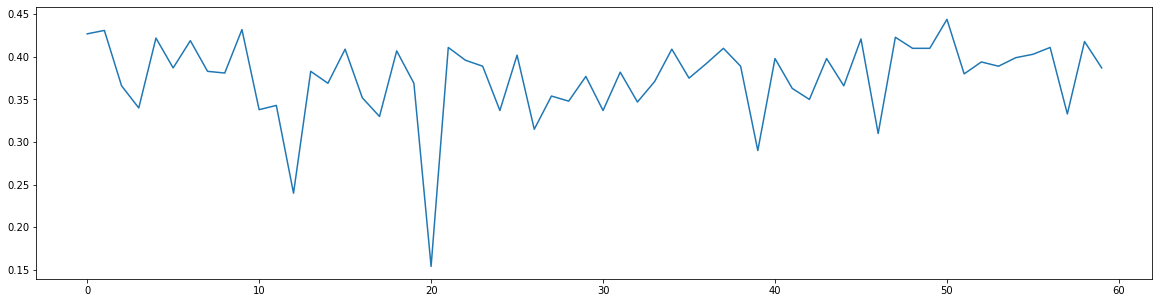

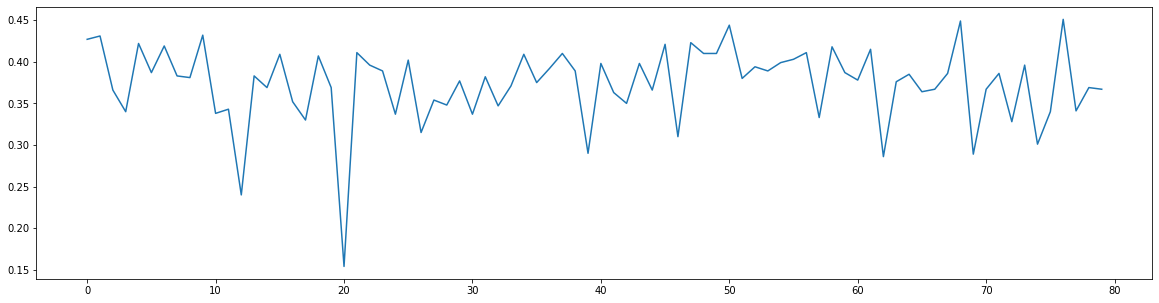

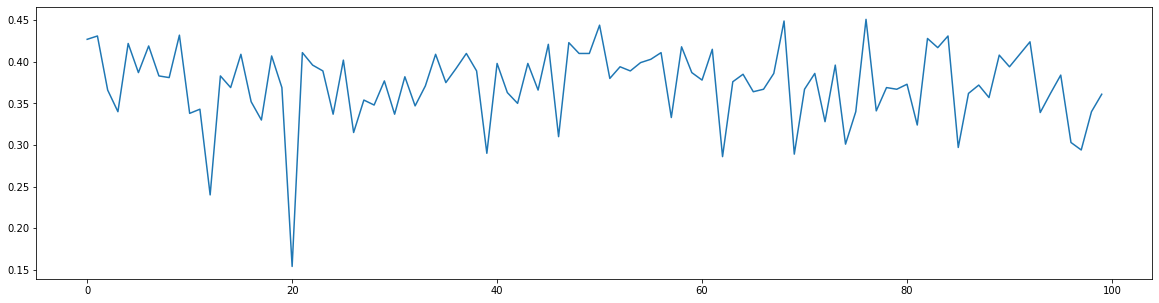

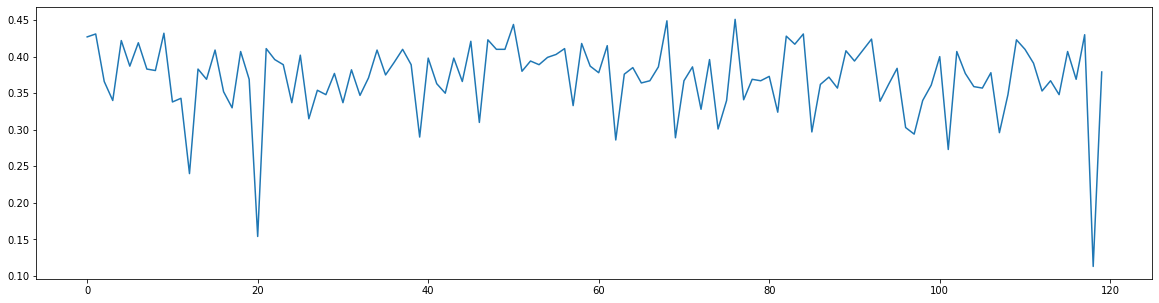

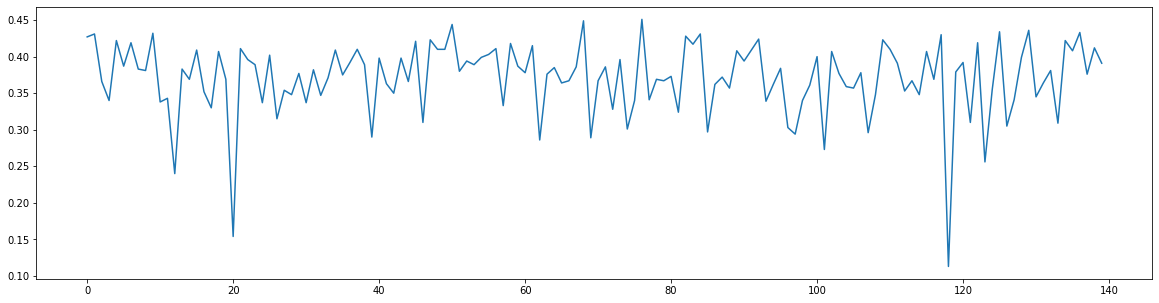

In [ ]:
if __name__ == '__main__':
    if is_train:
        # training loop
        for eps in range(N_EPISODE):
            state,_ =  env.reset()
            episode_reward = 0
            
            for epoch in range(inner_epochs):
                action = sac_trainer.policy_net.sample_action()
                next_state, reward, done, _, _ = env.step(action)    
                print(f"next_state:{next_state}")
                replay_buffer.push(state, action, reward, next_state, done)
                
                state = next_state
                episode_reward += reward
                
                if len(replay_buffer) > BATCH_SIZE:
                    for i in range(update_itr):
                        _=sac_trainer.update(BATCH_SIZE, reward_scale=10., auto_entropy=AUTO_ENTROPY, target_entropy=-1.*action_dim)

                if done:
                    break

            if eps % 20 == 0 and eps>0: # plot and model saving interval
                plot(rewards)
                np.save('rewards', rewards)
                sac_trainer.save_model(model_path)
            print('Episode: ', eps, '| Episode Reward: ', episode_reward)
            rewards.append(episode_reward)
        sac_trainer.save_model(model_path)

    if is_test:
        sac_trainer.load_model(model_path)
        for eps in range(10):
            state =  env.reset()
            episode_reward = 0

            for epoch in range(inner_epochs):
                action = sac_trainer.policy_net.get_action(state, deterministic = DETERMINISTIC)
                next_state, reward, done, _ = env.step(action)
                
                episode_reward += reward
                state=next_state

            print('Episode: ', eps, '| Episode Reward: ', episode_reward)